In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/heart_disease_health_indicators_BRFSS2015.csv')

In [5]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [116]:
df.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
       'Age', 'college_grad', 'high_income', 'good_mental_health',
       'good_general_health'],
      dtype='object')

In [6]:
df.shape

(253680, 22)

In [7]:
#check for NA values
df.isnull().values.any()

False

In [8]:
df.HeartDiseaseorAttack.value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

# Feature Engineering

Detailed descriptions of fields can be found in the CDC's codebook for the data here: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

In [9]:
#create dummy variable to indicate whether someone has a college degree
df['college_grad']= (df['Education'] == 6 ).astype(int)

#create variable to indicate whether someone makes more than $50,000 annually
df['high_income']= (df['Income'].isin([8,9]).astype(int))

#create variable to indicate whether people reported having poor mental health in more than 15 of the past 30 days
few_days = []
few_days.extend(range(1,15))
few_days.append(88)
df['good_mental_health']= (df['MentHlth'].isin(few_days).astype(int)) #88 is "None"

#create variable to indicate whether people report health as good/very good/excellent (1) vs fair/poor (0)
df['good_general_health']= (df['GenHlth'].isin([1,2,3]).astype(int)) 

df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,college_grad,high_income,good_mental_health,good_general_health
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,15.0,1.0,0.0,9.0,4.0,3.0,0,0,0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,7.0,6.0,1.0,1,0,0,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,30.0,1.0,0.0,9.0,4.0,8.0,0,1,0,0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,11.0,3.0,6.0,0,0,0,1
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,11.0,5.0,4.0,0,0,1,1


In [10]:
df.drop(columns = ['MentHlth','GenHlth','PhysHlth','Education','Income'], inplace=True)

In [11]:
df.Diabetes.value_counts()

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes, dtype: int64

Value of 2 for the Diabetes field is "Yes, but female told only during pregnancy" so I'll count it as Yes for diabetes.

In [12]:
df.Diabetes.replace(2,1, inplace=True)
df.Diabetes.value_counts()

0.0    213703
1.0     39977
Name: Diabetes, dtype: int64

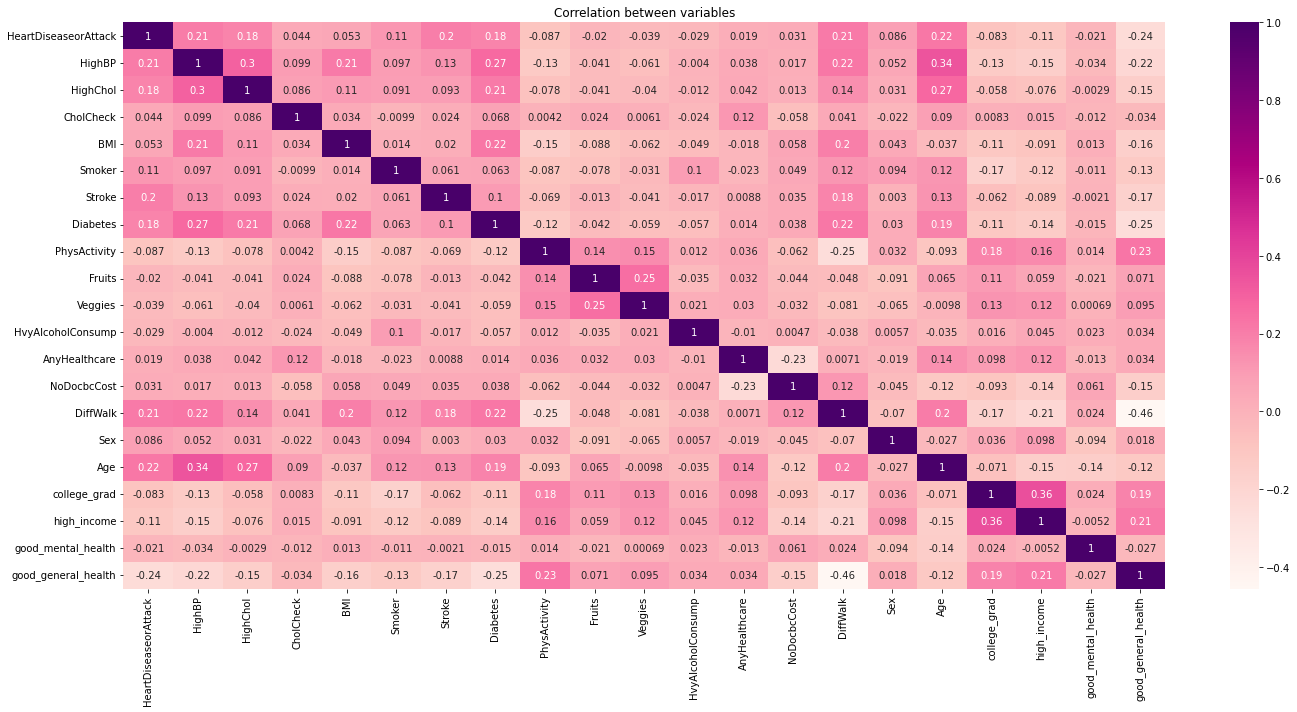

In [13]:
plt.subplots(figsize=(20,10))
feature_corr=df.corr()
sns.heatmap(feature_corr,annot=True,cmap='RdPu')
plt.title('Correlation between variables')
plt.xticks(rotation=90)
plt.tight_layout();

# Split and scale data

In [14]:
#drop several variables that show high correlation in the table above
X = df.drop(['HeartDiseaseorAttack'], axis=1)
y = df.HeartDiseaseorAttack

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify = y,
                                                   random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Quick detour to check VIF to see if there is problematic multicollinearity for logistic regression.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,HighBP,2.302320
1,HighChol,2.033872
2,CholCheck,21.481795
3,BMI,16.239262
4,Smoker,1.933629
5,Stroke,1.104151
6,Diabetes,1.416915
7,PhysActivity,4.581396
8,Fruits,3.022398
9,Veggies,5.701816


# Test several baseline models

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False)
neigh = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5)

models = [lr, rf, xgb, neigh]

model_scores = {'Model':['Logistic Regression','Random Forest','XGB','KNN'],
               'Neg Log Loss':[],'Precision':[],'Recall':[]}

for model in models:
    scores = cross_validate(
        model, X_train, y_train, cv=cv, 
        scoring = ('neg_log_loss','precision','recall'),
        return_train_score=True)
    model_scores['Neg Log Loss'].append(scores['test_neg_log_loss'])
    model_scores['Precision'].append(scores['test_precision'])
    model_scores['Recall'].append(scores['test_recall']) 

[18:40:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:40:54] WARNING: /Users/runner/miniforge3/cond

In [18]:
model_scores_df = pd.DataFrame.from_dict(model_scores)
model_scores_df[['Neg Log Loss','Precision','Recall']] = model_scores_df[['Neg Log Loss','Precision','Recall']].apply(
    lambda x: np.mean(x))
model_scores_df

,Model,Neg Log Loss,Precision,Recall
0,Logistic Regression,-0.569411,0.436016,0.133468
1,Random Forest,-0.583327,0.430173,0.131310
2,XGB,-0.582706,0.450384,0.137327
3,KNN,-0.565044,0.449495,0.135953


In [19]:
import joblib
joblib.dump(model_scores, 'baseline_model_scores.pkl')

['baseline_model_scores.pkl']

Let's move forward with trying to improve the XGB model.

## Get a baseline score for the XGB classifier

In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

#Estimate value to use for scale_pos_weight to account for imbalanced dataset
scale_pos_weight = y_train[y_train==0].count() / y_train[y_train==1].count()

xgb1 = XGBClassifier(booster='gbtree',
                     use_label_encoder = False,
                     learning_rate =0.1,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     scale_pos_weight=scale_pos_weight,
                     n_jobs = -1,
                     verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb1_scores = cross_validate(
    xgb1, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [21]:
print(f"Test precision: {xgb1_scores['test_precision']}")
print(f"Mean test precision: {np.mean(xgb1_scores['test_precision'])}")
print(f"Test recall: {xgb1_scores['test_recall']}")
print(f"Mean test recall: {np.mean(xgb1_scores['test_recall'])}")
print(f"Test neg log loss: {xgb1_scores['test_neg_log_loss']}")
print(f"Mean test neg log loss: {np.mean(xgb1_scores['test_neg_log_loss'])}\n")

Test precision: [0.23785504 0.23919552 0.23186871 0.23830532 0.23456025]
Mean test precision: 0.2363569663700278
Test recall: [0.80172639 0.8150667  0.80198797 0.81951347 0.79199372]
Mean test recall: 0.8060576507308692
Test neg log loss: [-0.4874831  -0.48890105 -0.49724812 -0.48816938 -0.49013181]
Mean test neg log loss: -0.4903866945510643



In [22]:
print(f'Initial estimate for scale_pos_weight for the baseline model is {scale_pos_weight}')

Initial estimate for scale_pos_weight for the baseline model is 9.617557811028565


## Tune max_depth and min_child_weight

Note that my tuning process follows advice from Analytics Vidhya outlined here: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [23]:
warnings.filterwarnings('ignore')

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

grid_search1 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      gamma=0,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1,
                                                      verbosity=0), 
                            param_grid=param_test1, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

X_val=X_train
y_val=y_train

fit_params={"early_stopping_rounds" : 20, 
            "eval_metric" : "logloss", 
            "eval_set" : [[X_val, y_val]],
            "verbose" : False}

grid_search1.fit(X_train, y_train, **fit_params)

grid_search1.cv_results_, grid_search1.best_params_, grid_search1.best_score_
print(f"Best: {grid_search1.best_score_} using {grid_search1.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best: -0.45556743949234246 using {'max_depth': 9, 'min_child_weight': 1}


In [24]:
joblib.dump(grid_search1, 'grid_search1.pkl')

['grid_search1.pkl']

Use min_child_weight of 1 going forward, but do another grid search to fine tune max_depth.

In [25]:
param_test2 = {
 'max_depth': range(9,22,3)
}

grid_search2 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      min_child_weight = 1,
                                                      gamma=0,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1,
                                                      verbosity=0), 
                            param_grid=param_test2, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search2.fit(X_train, y_train, **fit_params)

grid_search2.cv_results_, grid_search2.best_params_, grid_search2.best_score_
print(f"Best: {grid_search2.best_score_} using {grid_search2.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best: -0.35573701149691966 using {'max_depth': 21}


In [91]:
grid_search2.cv_results_

{'mean_fit_time': array([ 680.55745602,  911.85513463, 1211.9492291 , 3359.41326008,
        4404.478088  ]),
 'std_fit_time': array([ 30.18609537,  23.79276988,  55.938776  , 669.23341669,
        952.11059381]),
 'mean_score_time': array([0.05888457, 0.07927933, 0.13504357, 0.20871449, 0.22642479]),
 'std_score_time': array([0.00832055, 0.00799249, 0.03201449, 0.0366488 , 0.05381827]),
 'param_max_depth': masked_array(data=[9, 12, 15, 18, 21],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 9},
  {'max_depth': 12},
  {'max_depth': 15},
  {'max_depth': 18},
  {'max_depth': 21}],
 'split0_test_score': array([-0.45314974, -0.40037042, -0.36196198, -0.35247386, -0.35143424]),
 'split1_test_score': array([-0.45257451, -0.39942445, -0.36107174, -0.35026248, -0.34909779]),
 'split2_test_score': array([-0.46284556, -0.41250414, -0.37405888, -0.36536545, -0.36580607]),
 'split3_test_score': array([-0.4533996

In [26]:
joblib.dump(grid_search2, 'grid_search2.pkl')

['grid_search2.pkl']

The improvement from max_depth of 18 to 21 was limited, so we will set max_depth of 18 going forward.

## Tune gamma

In [27]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

grid_search3 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test3, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search3.fit(X_train, y_train, **fit_params)

grid_search3.cv_results_, grid_search3.best_params_, grid_search3.best_score_
print(f"Best: {grid_search3.best_score_} using {grid_search3.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best: -0.35543133452139447 using {'gamma': 0.2}


In [28]:
joblib.dump(grid_search3, 'grid_search3.pkl')

['grid_search3.pkl']

Use gamma of 0.2 going forward.

## Tune subsample and colsample_bytree

In [29]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid_search4 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      gamma=0.2,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test4, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search4.fit(X_train, y_train, **fit_params)

grid_search4.cv_results_, grid_search4.best_params_, grid_search4.best_score_
print(f"Best: {grid_search4.best_score_} using {grid_search4.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Best: -0.35385716426827857 using {'colsample_bytree': 0.8, 'subsample': 0.6}


In [30]:
joblib.dump(grid_search4, 'grid_search4.pkl')

['grid_search4.pkl']

Use colsample_bytree value of 0.8 and subsample value of 0.6 for final model.

## Tune regularization

In [31]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

grid_search5 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      gamma=0.2,
                                                      colsample_bytree=0.8,
                                                      subsample=0.6,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test5, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search5.fit(X_train, y_train, **fit_params)

grid_search5.cv_results_, grid_search5.best_params_, grid_search5.best_score_
print(f"Best: {grid_search5.best_score_} using {grid_search5.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best: -0.35390173115498313 using {'reg_alpha': 0.1}


In [32]:
joblib.dump(grid_search5, 'grid_search5.pkl')

['grid_search5.pkl']

Use reg_alpha of 0.1.

## Score model with current chosen hyperparameters and compare to the baseline model

In [33]:
warnings.filterwarnings('ignore')

xgb2 = XGBClassifier(use_label_encoder = False,
                          learning_rate=0.1,
                          n_estimators=500,
                          max_depth=18,
                          min_child_weight=1,
                          gamma=0.2,
                          colsample_bytree=0.8,
                          reg_alpha=0.1,
                          subsample=0.6,
                          objective= 'binary:logistic',
                          scale_pos_weight=scale_pos_weight,
                          n_jobs = -1,
                          verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb2_scores = cross_validate(
    xgb2, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [34]:
print(f"Test precision: {xgb2_scores['test_precision']}")
print(f"Mean test precision: {np.mean(xgb2_scores['test_precision'])}")
print(f"Test recall: {xgb2_scores['test_recall']}")
print(f"Mean test recall: {np.mean(xgb2_scores['test_recall'])}")
print(f"Test neg log loss: {xgb2_scores['test_neg_log_loss']}")
print(f"Mean test neg log loss: {np.mean(xgb2_scores['test_neg_log_loss'])}\n")

Test precision: [0.2573499  0.26300149 0.24980346 0.25885276 0.25495868]
Mean test precision: 0.256793256743481
Test recall: [0.32513733 0.32409103 0.33246142 0.32696835 0.32286761]
Mean test recall: 0.326305146095139
Test neg log loss: [-0.43422544 -0.43354464 -0.45353291 -0.43817425 -0.44576233]
Mean test neg log loss: -0.4410479144855259



In [35]:
model_score_compare = {'Model':['XGB Baseline','XGB Tuned'],
                      'Mean Precision':[np.mean(xgb1_scores['test_precision']), np.mean(xgb1_scores['test_precision'])],
                      'Mean Recall':[np.mean(xgb1_scores['test_recall']), np.mean(xgb2_scores['test_recall'])],
                      'Mean Negative Log Loss':[np.mean(xgb1_scores['test_neg_log_loss']),np.mean(xgb2_scores['test_neg_log_loss'])]
                      }
model_compare_df = pd.DataFrame.from_dict(model_score_compare)
model_compare_df

,Model,Mean Precision,Mean Recall,Mean Negative Log Loss
0,XGB Baseline,0.236357,0.806058,-0.490387
1,XGB Tuned,0.236357,0.326305,-0.441048


Let's compare that score to what happens if we reduce the learning rate and boost the number of trees.

In [36]:
warnings.filterwarnings('ignore')

xgb_final = XGBClassifier(use_label_encoder = False,
                          learning_rate=0.01,
                          n_estimators=500,
                          max_depth=18,
                          min_child_weight=1,
                          gamma=0.2,
                          colsample_bytree=0.8,
                          reg_alpha=0.1,
                          subsample=0.6,
                          objective= 'binary:logistic',
                          scale_pos_weight=scale_pos_weight,
                          n_jobs = -1,
                          verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb_final_scores = cross_validate(
    xgb_final, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [37]:
model_score_compare = {'Model':['XGB Baseline','XGB Tuned','XGB Final'],
                      'Mean Precision':[np.mean(xgb1_scores['test_precision']), np.mean(xgb1_scores['test_precision']),np.mean(xgb_final_scores['test_precision'])],
                      'Mean Recall':[np.mean(xgb1_scores['test_recall']), np.mean(xgb2_scores['test_recall']), np.mean(xgb_final_scores['test_recall'])],
                      'Mean Negative Log Loss':[np.mean(xgb1_scores['test_neg_log_loss']),np.mean(xgb2_scores['test_neg_log_loss']), np.mean(xgb_final_scores['test_neg_log_loss'])]
                      }
model_compare_df = pd.DataFrame.from_dict(model_score_compare)
model_compare_df

,Model,Mean Precision,Mean Recall,Mean Negative Log Loss
0,XGB Baseline,0.236357,0.806058,-0.490387
1,XGB Tuned,0.236357,0.326305,-0.441048
2,XGB Final,0.283340,0.514230,-0.351004


In [38]:
joblib.dump(model_compare_df, 'model_compare_df.pkl')

['model_compare_df.pkl']

That improved scores nicely. Let's move on to looking at potentially adjusting a few more things.

## Explore adjustment of class weighting

Split training data into training and validation data to do some predictions and look at PR curve and ROC curve. Note that I'll refit models on the new set of training data to minimize the effects of data leakage but even so, next time I would avoid this approach as I used the validation set in earlier steps to do some hyperparameter tuning. Learning for next time!

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)
X_val = scaler.transform(X_val)

In [42]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

def plot_pr_curve(y_actual, y_pred): 
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(
        y_actual, y_pred)
    fig=plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, suspect heart disease)');
    plt.title('Precision and Recall Curves')
    plt.tight_layout
    return fig

def plot_roc_curve(y_actual, y_pred):
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='XGB')
    display.plot()
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.show()

    
def print_confusion_matrix(y_actual, y_pred, threshold=0.5):
    y_pred_confusion = (y_pred >= threshold)
    confusion = confusion_matrix(y_actual, y_pred_confusion)
    plt.figure(dpi=100)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
               xticklabels=['No Heart Disease','Heart Disease'],
               yticklabels =['No Heart Disease','Heart Disease'],
               fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.title('Confusion Martix')
    plt.show()

Let's tune the class weighting hyperparameter and see if we can reduce the number of false negatives.

scale_pos_weight: 8.5


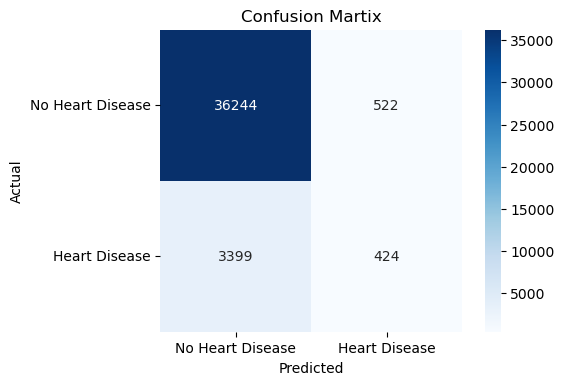

scale_pos_weight: 9


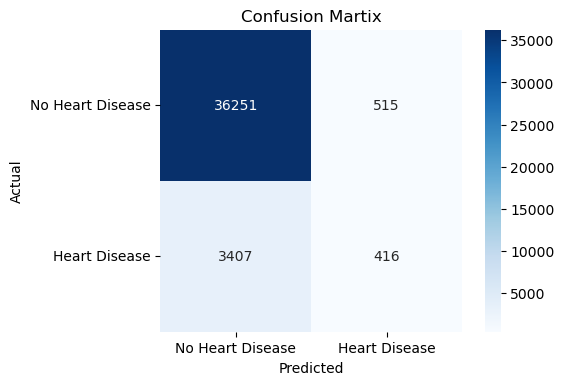

scale_pos_weight: 9.5


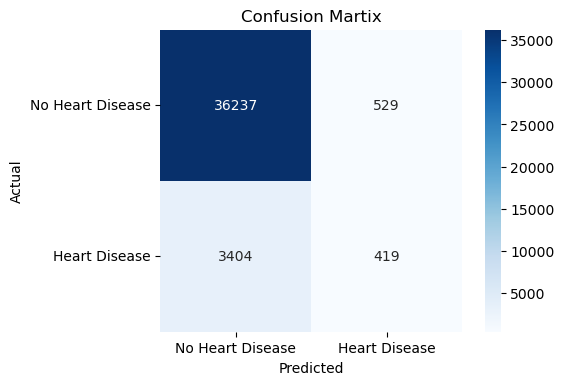

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score

weights = [8.5,9,9.5]
results={'scale_pos_weight':[],
        'Recall':[],
        'Precision':[]
        }

for i in weights:
    xgb_weight = XGBClassifier(scale_pos_weight=i,
                                  use_label_encoder = False,
                                  learning_rate=0.01,
                                  n_estimators=500,
                                  max_depth=18,
                                  min_child_weight=1,
                                  gamma=0.2,
                                  colsample_bytree=0.8,
                                  reg_alpha=0.1,
                                  subsample=0.6,
                                  objective= 'binary:logistic',
                                  n_jobs = -1,
                                  verbosity=0)
    xgb_weight.fit(X_train,y_train)
    y_pred = xgb_weight.predict(X_val)
    results['scale_pos_weight'].append(i)
    results['Recall'].append(recall_score(y_val,y_pred))
    results['Precision'].append(precision_score(y_val,y_pred))
    print(f'scale_pos_weight: {i}')
    print_confusion_matrix(y_val,y_pred)

Looks like a scale_pos_weight of 9 does a good job of minimizing false negatives. So we'll use that for our final model to predict the test data. 

# Adjust number of estimators

In [44]:
xgb = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=500,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [45]:
xgb.best_ntree_limit

500

Early stopping rounds never kicked in for 500 estimators, meaning the negative log loss was improving with each iteration. Let's bump up n_estimators and see if we can trigger early stopping rounds.

In [46]:
xgb_more_trees = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=5000,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb_more_trees.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

xgb_more_trees.best_ntree_limit

554

Early stopping rounds kicked in at 3094 estimators. Let's use that in our final model for n_estimators.

In [47]:
joblib.dump(xgb, 'xgb.pkl')

['xgb.pkl']

In [67]:
xgb_best = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=554,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb_best.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=554, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [68]:
joblib.dump(xgb_best, 'xgb_best.pkl')

['xgb_best.pkl']

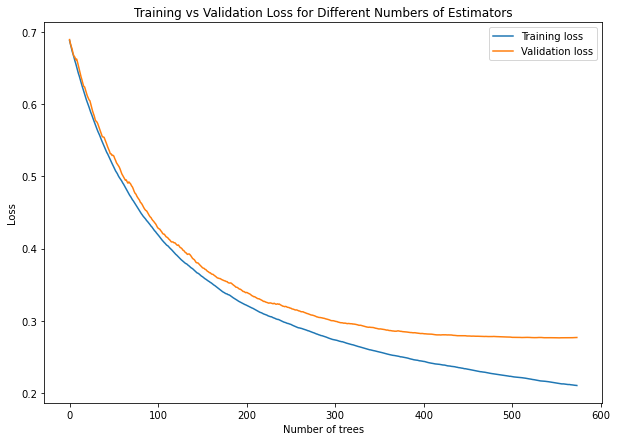

In [50]:
results = xgb_best.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.title('Training vs Validation Loss for Different Numbers of Estimators')
plt.legend();

# Explore threshold adjustment

XGBoost Model best F1 score 0.330 at prob decision threshold >= 0.161


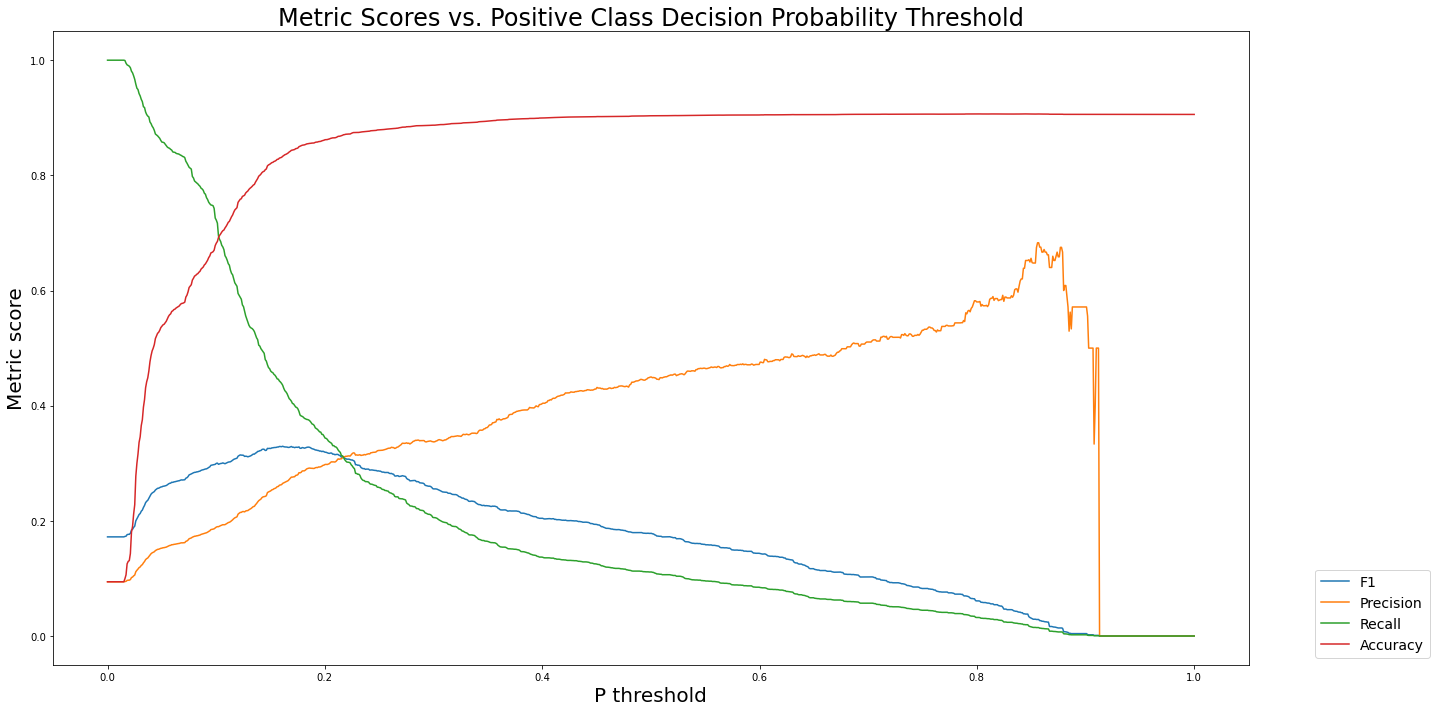

In [69]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

thresh_ps = np.linspace(0,1,1000)
model_val_probs = xgb_best.predict_proba(X_val)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))

plt.figure(figsize=(20,10))
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold', fontsize=24)
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left',fontsize=14)
plt.xlabel('P threshold', fontsize=20)
plt.ylabel('Metric score', fontsize=20)
plt.tight_layout()
plt.savefig('threshold_figure.png')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('XGBoost Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

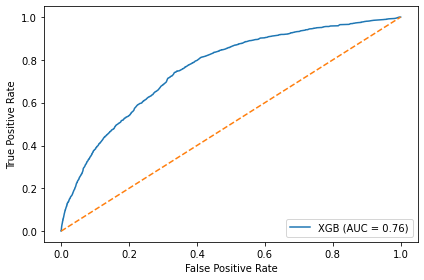

In [70]:
from sklearn.metrics import roc_curve
y_pred = xgb_best.predict_proba(X_val)[:,1]
plot_roc_curve(y_val, y_pred)

# Train final model on training and validation data and predict test data

In [71]:
#bring training and validation data back together for final model training
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

X_train = pd.concat([X_train,X_val])
y_train = pd.concat([y_train,y_val])

In [72]:
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=554, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

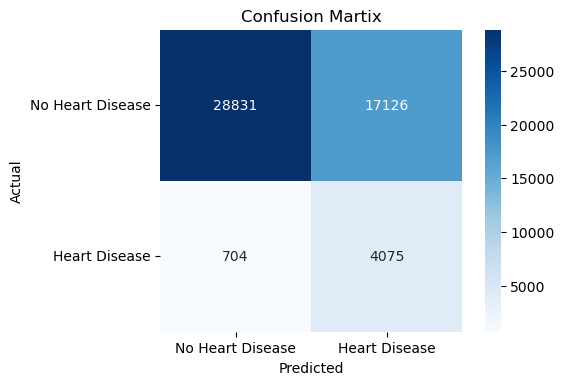

In [73]:
y_pred = xgb_best.predict_proba(X_test)[:,1]

#use 0.161 as threshold, which we saw maximized f1 score when tested on validation data above
y_pred = np.where(y_pred>=0.161, 1, 0)
print_confusion_matrix(y_test, y_pred)

In [74]:
from ipywidgets import interactive, FloatSlider
y_pred = xgb_best.predict_proba(X_test)[:,1]
interactive(lambda threshold: print_confusion_matrix(y_test, y_pred, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

# Extract feature importance

In [75]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Age',
       'college_grad', 'high_income', 'good_mental_health',
       'good_general_health'],
      dtype='object')

In [76]:
xgb_best.get_booster().feature_names = ['High Blood Pressure', 'High Cholesterol', 'Chol Check', 'BMI', 
                                   'Smoker', 'Stroke', 'Diabetes', 'Physical Activity', 'Fruits', 'Veggies', 
                                   'Heavy Alcohol Consump','Any Healthcare', 'No Doc Because Cost', 
                                   'Difficulty Walking', 'Sex', 'Age', 'College Grad', 'High Income', 
                                   'Good Mental Health', 'Good General Health']

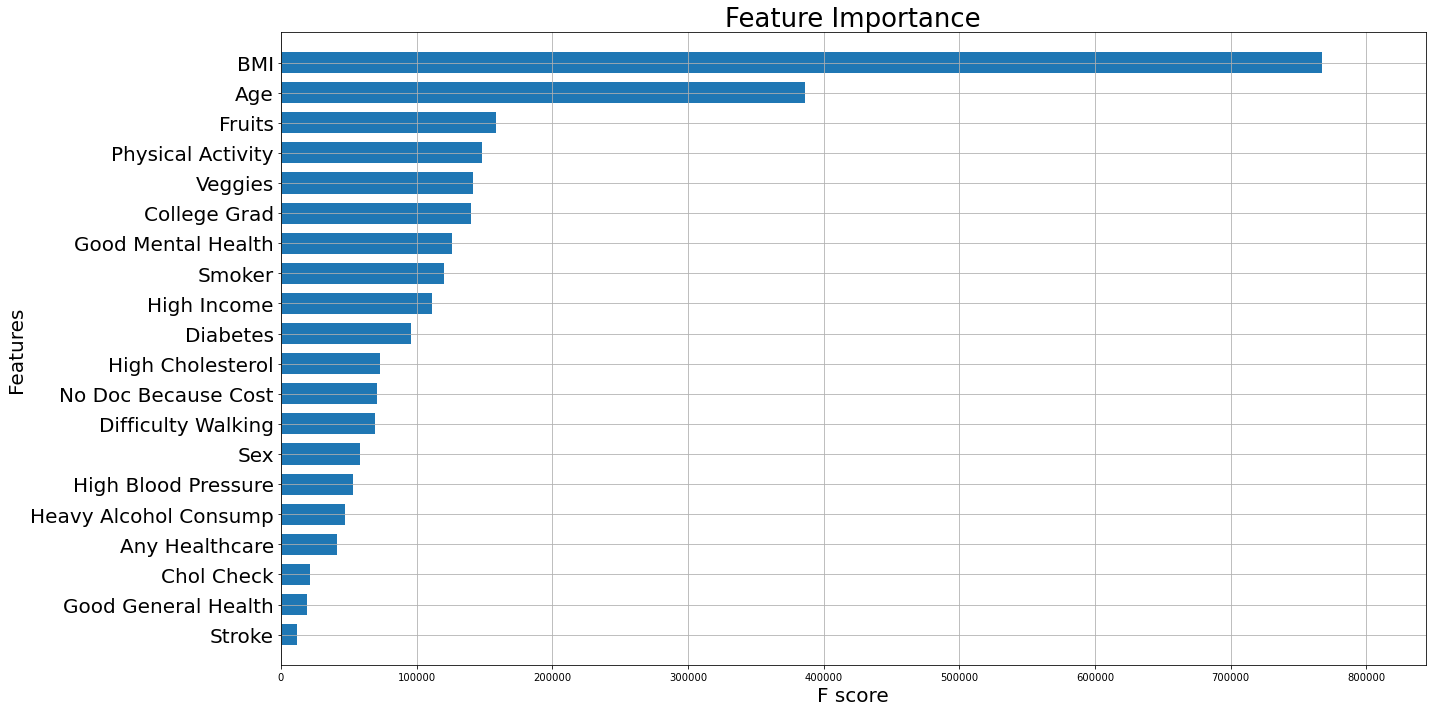

In [77]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20, 10))
plt.yticks(fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.xlabel('F Score', fontsize=20)
plt.title('Feature Importance', fontsize=26)
plot_importance(booster=xgb_best, ax=ax, title=None, height=0.7, show_values=False)
plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import precision_score, recall_score

y_pred = xgb_best.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred>=0.161, 1, 0)

print(f'Final precision score: {precision_score(y_test, y_pred)}')
print(f'Final recall score: {recall_score(y_test,y_pred)}')

Final precision score: 0.19220791472100374
Final recall score: 0.8526888470391295


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.63      0.76     45957
         1.0       0.19      0.85      0.31      4779

    accuracy                           0.65     50736
   macro avg       0.58      0.74      0.54     50736
weighted avg       0.90      0.65      0.72     50736



In [83]:
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred>=0.161, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.41      0.58     45957
         1.0       0.15      0.97      0.25      4779

    accuracy                           0.46     50736
   macro avg       0.57      0.69      0.42     50736
weighted avg       0.91      0.46      0.55     50736



# Compare baseline random forest model to the trained XGB model

In [108]:
rf.fit(X_train, y_train)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [109]:
y_pred_rf = rf.predict(X_test)

In [110]:
pred_compare = (y_pred_rf == y_pred)

In [114]:
pred_compare_list = list(zip(y_test, pred_compare))
compare_df = pd.DataFrame(pred_compare_list, columns = ['y_test', 'rf and xgb agree'])

In [115]:
compare_df.value_counts()

y_test  rf and xgb agree
0.0     True                30214
        False               15743
1.0     False                3319
        True                 1460
dtype: int64